# Treinamento do Modelo Baseline (LarvaeNet)

Este notebook realiza o treinamento do modelo baseline de convolução para classificação de imagens de larvas.   
O pipeline inclui:
- preparação do dataset
- definição do modelo
- treinamento
- avaliação
- salvamento do modelo treinado
- visualização das projeções
- visualição GRAMCAM.

# Import Dependences

In [ ]:
# instalando torch para gpu integrada do mac - suporte a GPU Metal
# !pip install torch torchvision torchaudio -f https://download.pytorch.org/whl/metal.html

In [1]:
import torch
from torch import nn as nn
import math
from glob import glob
#from torchsummary import summary
from torchinfo import summary
from torch_snippets import *
from torch_snippets.torch_loader import Report
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split
import os
import warnings
from larvae_utils import *
#from model_blocks import *  # Importando os novos modelos

In [2]:
warnings.filterwarnings("ignore")

In [3]:
# is GPU available?
# gpu = torch.cuda.is_available()
# mudando para verificar gpu integrada do mac
gpu = torch.backends.mps.is_available()

# defining device where to to the computation
device = torch.device("mps") if gpu else torch.device("cpu")
print('Usando device: ', device)

Usando device:  mps


# Dataset and split

In [4]:
orig_dir = '../../figures-datasets/images/larvae'  # changing for larvae folder
nclasses = 2

# Set the desired image size for rescaling and maximum value for normalization
# using the same size as the corel version
width = 224
height = 224
nchannels = 3
maxval = 255.
input_shape = (nchannels, height, width)

# Set percentages for train, validation and test
train_perc = 0.50  # 50% of the dataset for training
valid_perc = 0.20  # 20% of the dataset for validation
test_perc = 0.30  # 30% of the dataset for testing

# get the list of images in the original folder
data = glob(orig_dir+"/*.png")  # it returns a list of image filenames

# Set output model name
model_name = 'LarvaeNetBase.pth'

In [5]:
# checando proporção de targets e não targets (larvae e não larvae)
print("Original dataset:")
check_targets(data)

Original dataset:
Total: 1598
Targets: 247
Não Targets: 1351
Proporção: 0.15456821026282855


In [6]:
# o dataset é desbalanceado, prop de targets = 0.15
# criando split com stratified sampling

labels = [1 if "000001_" in str(x) else 0 for x in data]

# Primeiro split: treino + resto
trainset, temp_set, train_labels, temp_labels = train_test_split(
    data, labels, test_size=(1-train_perc), random_state=42, stratify=labels
)

# Segundo split: validação + teste
valid_size = valid_perc / (valid_perc + test_perc)
validset, testset, valid_labels, test_labels = train_test_split(
    temp_set, temp_labels, test_size=(1-valid_size), random_state=42, stratify=temp_labels
)

In [7]:
print("Trainset:")
check_targets(trainset)
print("Validset:")
check_targets(validset)
print("Testset:")
check_targets(testset)

Trainset:
Total: 799
Targets: 124
Não Targets: 675
Proporção: 0.15519399249061328
Validset:
Total: 319
Targets: 49
Não Targets: 270
Proporção: 0.1536050156739812
Testset:
Total: 480
Targets: 74
Não Targets: 406
Proporção: 0.15416666666666667


In [12]:
# checando proporção de treino, validação e teste
len(trainset)/len(data), len(validset)/len(data), len(testset)/len(data)

(0.5, 0.19962453066332916, 0.30037546933667086)

In [16]:
import pickle

# Salvando os datasets e labels em arquivos .pkl
with open('datasets/trainset.pkl', 'wb') as f:
    pickle.dump({'data': trainset, 'labels': train_labels}, f)

with open('datasets/validset.pkl', 'wb') as f:
    pickle.dump({'data': validset, 'labels': valid_labels}, f)

with open('datasets/testset.pkl', 'wb') as f:
    pickle.dump({'data': testset, 'labels': test_labels}, f)

print("Datasets salvos em arquivos .pkl")

Datasets salvos em arquivos .pkl


## Visualizando exemplos de cada classe

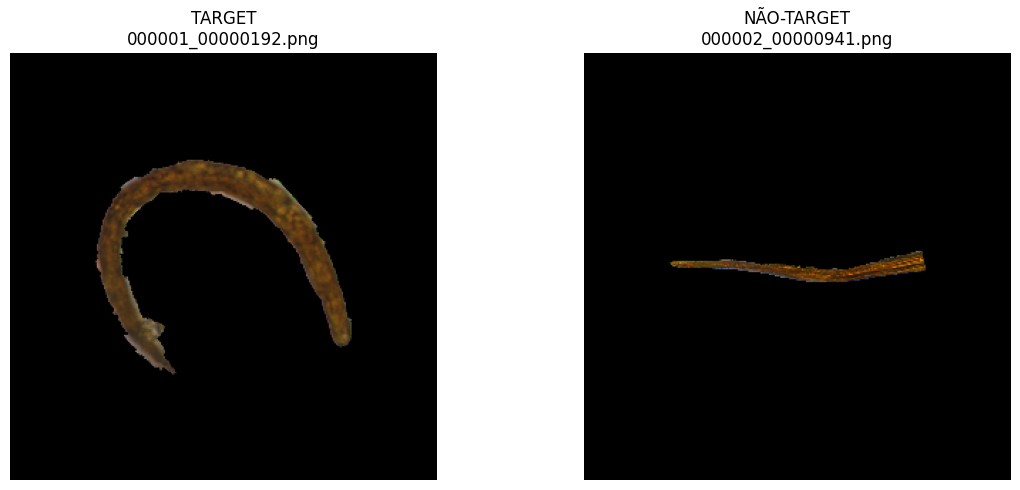

In [17]:
targets = [x for x in data if "000001_" in str(x)]
nao_targets = [x for x in data if "000001_" not in str(x)]

exemplo_target = targets[np.random.randint(0, len(targets))]
exemplo_nao_target = nao_targets[np.random.randint(0, len(nao_targets))]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Imagem Target
img_target = Image.open(exemplo_target)
axes[0].imshow(img_target)
axes[0].set_title(f"TARGET\n{exemplo_target.split('/')[-1]}")
axes[0].axis('off')

# Imagem Não-Target
img_nao_target = Image.open(exemplo_nao_target)
axes[1].imshow(img_nao_target)
axes[1].set_title(f"NÃO-TARGET\n{exemplo_nao_target.split('/')[-1]}")
axes[1].axis('off')

plt.tight_layout()
plt.show()

## Create image datasets

In [8]:
# Regular preprocessing transformation. The input is a PIL image, which after being resized,
# it is converted into a tensor for normalization using the ImageNet mean and stdev parameters.
prep = transforms.Compose([
    transforms.Resize(
        (224, 224),
        interpolation=transforms.InterpolationMode.BILINEAR,
        max_size=None, antialias=True
    ),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])


# Data augmentation
aug = transforms.Compose([
    # redimensiona a imagem para 300x300
    transforms.Resize(
        (300, 300), 
        interpolation=transforms.InterpolationMode.BILINEAR,
        max_size=None, antialias=True
    ),
    # aplica transformações (rotação, translação, escala e cisalhamento)
    transforms.RandomAffine(
        degrees=10,             # rotação de 10 graus aleatoria
        translate=(0.05, 0.10), # translacao: 5% horizontal e 10% vertical
        scale=(0.9, 1.1),       # escala: 90% a 110% do tamanho original
        shear=(-2, 2),          # cisalhamento: -2 a 2 graus
        interpolation=transforms.InterpolationMode.BILINEAR,  # interpolação bilinear
        fill=0                  # preenche áreas vazias com 0
    ),
    # corta centro da imagem para 250x250
    transforms.CenterCrop(250),
    # redimensiona para 224x224 (tamanho da entrada do modelo)
    transforms.Resize(
        (224, 224), 
        interpolation=transforms.InterpolationMode.BILINEAR,
        max_size=None, antialias=True
    ),
    # converte para tensor
    transforms.ToTensor(),
    # normaliza os valores para o intervalo [0,1]
    transforms.Normalize(
        # media RGB do ImageNet
        mean=(0.485, 0.456, 0.406),
        # dp do ImageNet
        std=(0.229, 0.224, 0.225)
    )
])

# Create an image dataset by applying one of the preprocessing transformations above
class ImageDataset():  
    def __init__(self, dataset, transform=None):
        # it gets the image true labels and set the preprocessing transformation
        self.dataset = dataset
        self.targets = [int(str(x).split("/")[-1].split("_")[0])-1 for x in self.dataset]
        self.transform = transform

    def __len__(self): return len(self.dataset)

    def __getitem__(self, ix):  # returns the item at position ix
        filename = self.dataset[ix]
        target = self.targets[ix]
        image = Image.open(filename)  # It is a PIL image
        if (self.transform is not None):
            image = self.transform(image)
        else:  # just reshape the image as a tensor with nchannels, height, width
            image = torch.from_numpy(np.array(image)).permute(2, 0, 1).float()
        return (image, target)

In [9]:
# verify the difference with and wothout data augmentation
trainset_ = trainset.copy()
trainset = ImageDataset(trainset_, aug)

validset = ImageDataset(validset, prep)
testset = ImageDataset(testset, prep)

# no trainset aplicamos data augmentation (aug)
# no validset e testset aplicamos apenas a normalização (prep)

## Visualize selected images

### Diferences between original image and data aug image from trainset

642


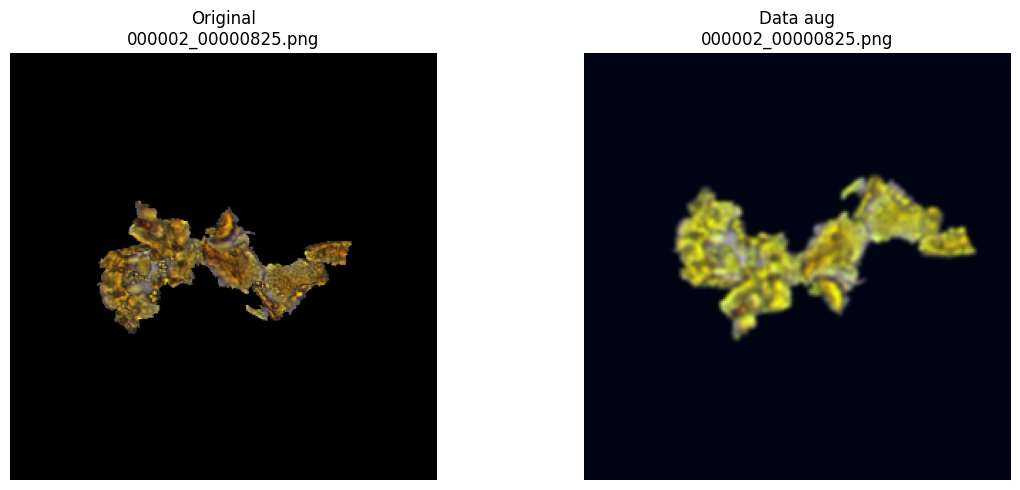

In [20]:
ex = np.random.randint(0, len(trainset_))
print(ex)
exemplo_original = trainset_[ex]
exemplo_transf, target = trainset[ex]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Imagem original
img_original = Image.open(exemplo_original)
axes[0].imshow(img_original)
axes[0].set_title(f"Original\n{exemplo_original.split('/')[-1]}")
axes[0].axis('off')

# Imagem data augmentation
exemplo_transf = exemplo_transf.permute(1, 2, 0).numpy()
exemplo_transf = 255*(exemplo_transf - np.min(exemplo_transf)) / \
    (np.max(exemplo_transf)-np.min(exemplo_transf))
exemplo_transf = exemplo_transf.astype('uint8')
axes[1].imshow(exemplo_transf)
axes[1].set_title(f"Data aug\n{exemplo_original.split('/')[-1]}")
axes[1].axis('off')

plt.tight_layout()
plt.show()

## Generate batches with batchsize images at random

In [10]:
from torch.utils.data import WeightedRandomSampler

# Weighted sampler para lidar com desbalanceamento
labels_train = [1 if "000001_" in str(x) else 0 for x in trainset]
class_sample_count = np.array([len(np.where(np.array(labels_train)==t)[0]) for t in np.unique(labels_train)])
weights = 1. / class_sample_count
samples_weights = np.array([weights[t] for t in labels_train])
sampler = WeightedRandomSampler(samples_weights, len(samples_weights), replacement=True)

In [11]:
batchsize = 32  # batch size = numero de imagens por lote
trainload = DataLoader(trainset, batch_size=batchsize, sampler=sampler)
testload = DataLoader(testset, batch_size=batchsize, shuffle=True)
validload = DataLoader(validset, batch_size=batchsize, shuffle=True)

next(iter(trainload))  # inspect next item in the trainload

[tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           ...,
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
          [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           ...,
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
          [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
           [-

# ConvNet Model

In [146]:
# a convolutional block
def conv_block(nchannels_in, nchannels_out, stride_val):
    return nn.Sequential(
        # defining convolutional layer
        nn.Conv2d(
            in_channels=nchannels_in, 
            out_channels=nchannels_out, 
            kernel_size=(5, 5),
            stride=1, 
            padding=2, 
            bias=False
        ),
        # defining a batch normalization layer, which dismisses the need for bias in the previous conv layer
        nn.BatchNorm2d(num_features=nchannels_out),
        # defining activation layer
        nn.ReLU(),
        # defining a pooling layer
        nn.MaxPool2d(kernel_size=(3, 3), stride=stride_val, padding=1)
    )


class LarvaeNet(nn.Module):

    def __init__(self, input_shape, num_classes):
        super(LarvaeNet, self).__init__()

        # defining feature extractor (camadas convolucionais)
        self.features = nn.Sequential(
            conv_block(input_shape[0], 32, 2), # 3 canais de entrada, 32 canais de saída, stride=2
            conv_block(32, 256, 2)             # 32 canais de entrada, 256 canais de saída, stride=2
        )

        # defining classifier
        self.classifier = nn.Sequential(
            nn.Linear(
                in_features=input_shape[1]//4*input_shape[2]//4*256, 
                out_features=64, 
                bias=True
            ),
            nn.Dropout(0.20),
            nn.ReLU(),
            nn.Linear(64, nclasses)
        )

        # initialize weights
        self._initialize_weights()

    def forward(self, x):
       # extracts features
        x = self.features(x)

        # transforms outputs into a 2D tensor
        x = torch.flatten(x, start_dim=1)

        # classifies features
        y = self.classifier(x)

        return y

    def _initialize_weights(self):
        # for each submodule of our network
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # get the number of elements in the layer weights
                n = m.kernel_size[0] * m.kernel_size[1] * m.in_channels
                # initialize layer weights with random values generated from a normal
                # distribution with mean = 0 and std = sqrt(2. / n))
                m.weight.data.normal_(mean=0, std=math.sqrt(2. / n))

                if m.bias is not None:
                    # initialize bias with 0
                    m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                # initialize layer weights with random values generated from a normal
                # distribution with mean = 0 and std = 1/100
                m.weight.data.normal_(mean=0, std=0.01)
                if m.bias is not None:
                    # initialize bias with 0
                    m.bias.data.zero_()

## Create the model

In [147]:
model = LarvaeNet(input_shape, nclasses).to(device)
#summary(model, input_shape, device=device)
print(model)

LarvaeNet(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=(3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(32, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=(3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
    )
  )
  (classifier): Sequential(
    (0): Linear(in_features=802816, out_features=64, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=2, bias=True)
  )
)


### Define loss function with L2 regularization

In [134]:
def Criterion(model, preds, targets):
    ce = nn.CrossEntropyLoss().to(device)
    loss = ce(preds, targets.long())
    # add l2_regularization
    l2_regularization = 0
    for param in model.parameters():
        l2_regularization += torch.norm(param, 2)
    loss += 0.0001*l2_regularization  # 0.0001 is the weight_decay
    # compute mean accuracy in the batch
    pred_labels = torch.max(preds, 1)[1]  # same as argmax
    acc = torch.sum(pred_labels == targets.data)
    n = pred_labels.size(0)
    acc = acc/n
    kappa = cohen_kappa_score(pred_labels.cpu().numpy(),targets.data.cpu().numpy())
    return loss, acc, kappa

criterion = Criterion

### Define optimizer and learning scheduler

In [135]:
optimizer = optim.Adam(model.parameters(), lr=1e-5)
# gamma=0.9 is a multiplicative factor for lr decay at every epoch
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.9)
# gamma=0.9 is a multiplicative factor for lr decay at every step_size=number of epochs
#lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)

In [136]:
## clean up memory if needed
import gc
# del trainset, validset, testset
gc.collect()
torch.cuda.empty_cache()

### Define training and validation funcions

In [30]:
# Função para treinamento de modelo
def train_batch(model, data, optimizer, criterion, device):
    model.train()
    ims, targets = data
    ims = ims.to(device=device)
    targets = targets.to(device=device)
    preds = model(ims)
    loss, acc, kappa = criterion(model, preds, targets)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss.item(), acc.item(), kappa

# Função para validação de modelo
@torch.no_grad()
def validate_batch(model, data, criterion, device):
    model.eval()
    ims, targets = data
    ims = ims.to(device=device)
    targets = targets.to(device=device)
    preds = model(ims)
    loss, acc, kappa = criterion(model, preds, targets)
    return loss.item(), acc.item(), kappa

## Train the model and report results

In [148]:
# initializing variables
n_epochs = 50
log = Report(n_epochs)

# starting training and validation
for ex in range(n_epochs):
    N = len(trainload)
    for bx, data in enumerate(trainload):
        loss, acc, kappa = train_batch(model, data, optimizer, criterion, device)
        # report results for the batch
        log.record((ex+(bx+1)/N), trn_loss=loss, trn_acc=acc, trn_kappa=kappa, end='\r')

    N = len(validload)
    for bx, data in enumerate(validload):
        loss, ac, kappa = validate_batch(model, data, criterion, device)
        log.record((ex+(bx+1)/N), val_loss=loss, val_acc=acc, val_kappa=kappa, end='\r')

    if (ex+1) % 10 == 0: 
        log.report_avgs(ex+1)
    # count epochs for auto-adjusting the learning rate
    lr_scheduler.step()  # lr decay

EPOCH: 10.000  trn_kappa: -0.028  val_loss: 0.572  trn_acc: 0.671  val_acc: 0.790  val_kappa: 0.020  trn_loss: 0.621  (162.71s - 650.84s remaining)
EPOCH: 20.000  trn_kappa: 0.017  val_loss: 0.582  trn_acc: 0.683  val_acc: 0.548  val_kappa: 0.053  trn_loss: 0.618  (322.87s - 484.31s remaining)
EPOCH: 30.000  trn_kappa: 0.000  val_loss: 0.575  trn_acc: 0.697  val_acc: 0.635  val_kappa: 0.009  trn_loss: 0.616  (504.35s - 336.24s remaining)
EPOCH: 40.000  trn_kappa: 0.036  val_loss: 0.586  trn_acc: 0.696  val_acc: 0.635  val_kappa: 0.022  trn_loss: 0.612  (3399.27s - 849.82s remaining)
EPOCH: 50.000  trn_kappa: 0.097  val_loss: 0.572  trn_acc: 0.707  val_acc: 0.623  val_kappa: 0.006  trn_loss: 0.609  (5475.96s - 0.00s remaining)


## Plot results

100%|██████████| 151/151 [00:00<00:00, 12996.92it/s]


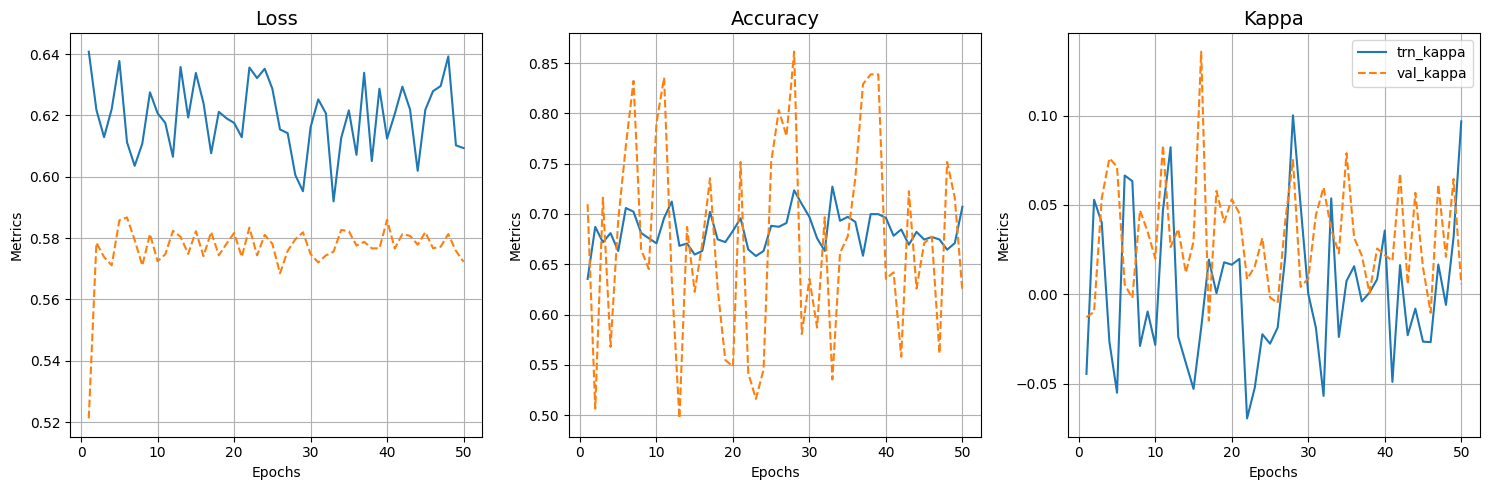

In [149]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# plot loss
log.plot_epochs(['trn_loss', 'val_loss'], ax=axes[0])
axes[0].set_title('Loss', fontsize=14)

# plot accuracy
log.plot_epochs(['trn_acc', 'val_acc'], ax=axes[1])
axes[1].set_title('Accuracy', fontsize=14)

# plot kappa
log.plot_epochs(['trn_kappa', 'val_kappa'], ax=axes[2])
axes[2].set_title('Kappa', fontsize=14)

plt.tight_layout()
plt.show()

## Evaluate model

In [45]:
def Test(model, testload, criterion, device):
    N = len(testload)
    mean_loss = 0
    mean_acc = 0
    mean_kappa = 0
    for bx, data in enumerate(testload):
        loss, acc, kappa = validate_batch(model, data, criterion, device)
        mean_loss += loss
        mean_acc += acc
        mean_kappa += kappa
    mean_loss = mean_loss / N
    mean_acc = mean_acc / N
    mean_kappa = mean_kappa / N
    return (mean_loss, mean_acc, mean_kappa)

In [144]:
# Test defined in larvae_utils.py
(loss, acc, kappa) = Test(model, testload, criterion, device)
print('Loss: {:.6f} Acc: {:.6f} Kappa: {:.6f}'.format(loss, acc, kappa))

Loss: 1.000469 Acc: 0.166667 Kappa: -0.002144


# Visualize Results

## Feature Maps

Mostra os mapas de ativação da última camada convolucional para uma imagem.

### For correct classificaction

In [109]:
# Verificar um exemplo de classificação correta da rede no conjunto de teste
model = model.to(device)
model.eval()
with torch.no_grad():
    for ims, targets in validload:
        ims = ims.to(device)
        targets = targets.to(device)
        outputs = model(ims)
        preds = torch.argmax(outputs, dim=1)
        correct_mask = preds == targets
        if correct_mask.any():
            idx = correct_mask.nonzero(as_tuple=True)[0][0].item()
            break

# idx é o índice do exemplo de classificação correta
image, target = validset[idx] # get idx th image from trainset
image.size() # it is a tensor with shape (nchannels, height, width)
image = image.unsqueeze(0) # add batch dimension

In [58]:
# Função para extrair feature map da parte convolucional da rede 
def get_feature_map(model, input_tensor: torch.Tensor) -> torch.Tensor:
    model.eval()
    with torch.no_grad():
        feature_map = model.features(input_tensor) # extrai features da parte convolucional
    return feature_map

In [ ]:
feature_map = get_feature_map(model, image) # get feature map from the first layer
feature_map.size() # it is a tensor with shape (batch_size, nchannels_out, height_out, width_out)

torch.Size([1, 256, 56, 56])

In [62]:
def save_feature_map_as_image(feature_map: torch.Tensor, outputdir: str) -> None:
    # remove batch dimension
    feature_map = feature_map[0] # shape: [C, H, W]
    
    # criando diretorio de saída se não existir
    os.makedirs(outputdir, exist_ok=True)

    for i in range(feature_map.shape[0]):
        fmap = feature_map[i].cpu().numpy()
        # normalize the feature map values to the range [0, 255]
        fmap_norm = 255 * (fmap - np.min(fmap)) / (np.max(fmap) - np.min(fmap))
        # convert the feature map to the uint8 data type
        fmap_norm = fmap_norm.astype(np.uint8)
        # save the feature map as an image
        img = Image.fromarray(fmap_norm)
        img.save(os.path.join(outputdir, f'feature_map_channel_{i}.png'))

In [63]:
# salva os feature maps como imagem
# feature_map: tensor com os mapas de características extraídos para cada canal
save_feature_map_as_image(feature_map, 'feature_maps/baseline')  #

In [64]:
# Função para visualizar feature maps
def visualize_features(feature_map: torch.Tensor,
                       max_channels: int = 16,
                       start_channel: int = 0,
                       figsize: tuple = (15, 10),
                       sample_idx: int = 0
                       ) -> None:
    """
    Visualize LarvaeNet feature maps

    Args:
        feature_map: Feature map tensor (batch_size, channels, height, width)
        max_channels: Maximum number of channels to display
        start_channel: Starting channel index (0-based)
        figsize: Figure size for matplotlib
        sample_idx: Which sample from the batch to visualize
    """
    # seleciona sample do batch, se for 4D (batch, canais, altura, largura)
    if feature_map.dim() == 4:
        # Shape: (channels, height, width)
        feature_map_sample = feature_map[sample_idx]
    else:
        feature_map_sample = feature_map

    # define total de canais e o intervalo de canais a serem visualizados
    total_channels = feature_map_sample.shape[0]
    end_channel = min(start_channel + max_channels, total_channels)
    num_channels = end_channel - start_channel

    if start_channel >= total_channels:
        raise ValueError(
            f"start_channel ({start_channel}) must be less than total channels ({total_channels})")

    print(f"Feature map shape: {feature_map.shape}")
    print(f"Total channels: {total_channels}")
    print(f"Visualizing channels {start_channel}-{end_channel-1} from sample {sample_idx}")

    # Calculate grid dimensions (max 4 col, rows definido de acordo)
    cols = 4
    rows = (num_channels + cols - 1) // cols

    # cria grid de canais
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()

    # para cada canal, cria um subplot
    for i in range(num_channels):
        ax = axes[i]
        channel_idx = start_channel + i  # indice do canal
        # extrai canal, move para cpu e converte para numpy
        channel_data = feature_map_sample[channel_idx].cpu().numpy()

        # plota como imagem
        im = ax.imshow(channel_data, cmap='viridis')
        ax.set_title(f'Channel {channel_idx}\nMin: {channel_data.min():.2f}\nMax: {channel_data.max():.2f}',
                     fontsize=10)
        ax.axis('off')
        plt.colorbar(im, ax=ax, shrink=0.6)

    # Hide unused subplots
    for i in range(num_channels, len(axes)):
        axes[i].axis('off')

    plt.suptitle(f'LarvaeNet Feature Maps - Channels {start_channel}-{end_channel-1}\nShape: {feature_map.shape}',
                 fontsize=14)
    plt.tight_layout()
    plt.show()

Feature map shape: torch.Size([1, 256, 56, 56])
Total channels: 256
Visualizing channels 32-47 from sample 0


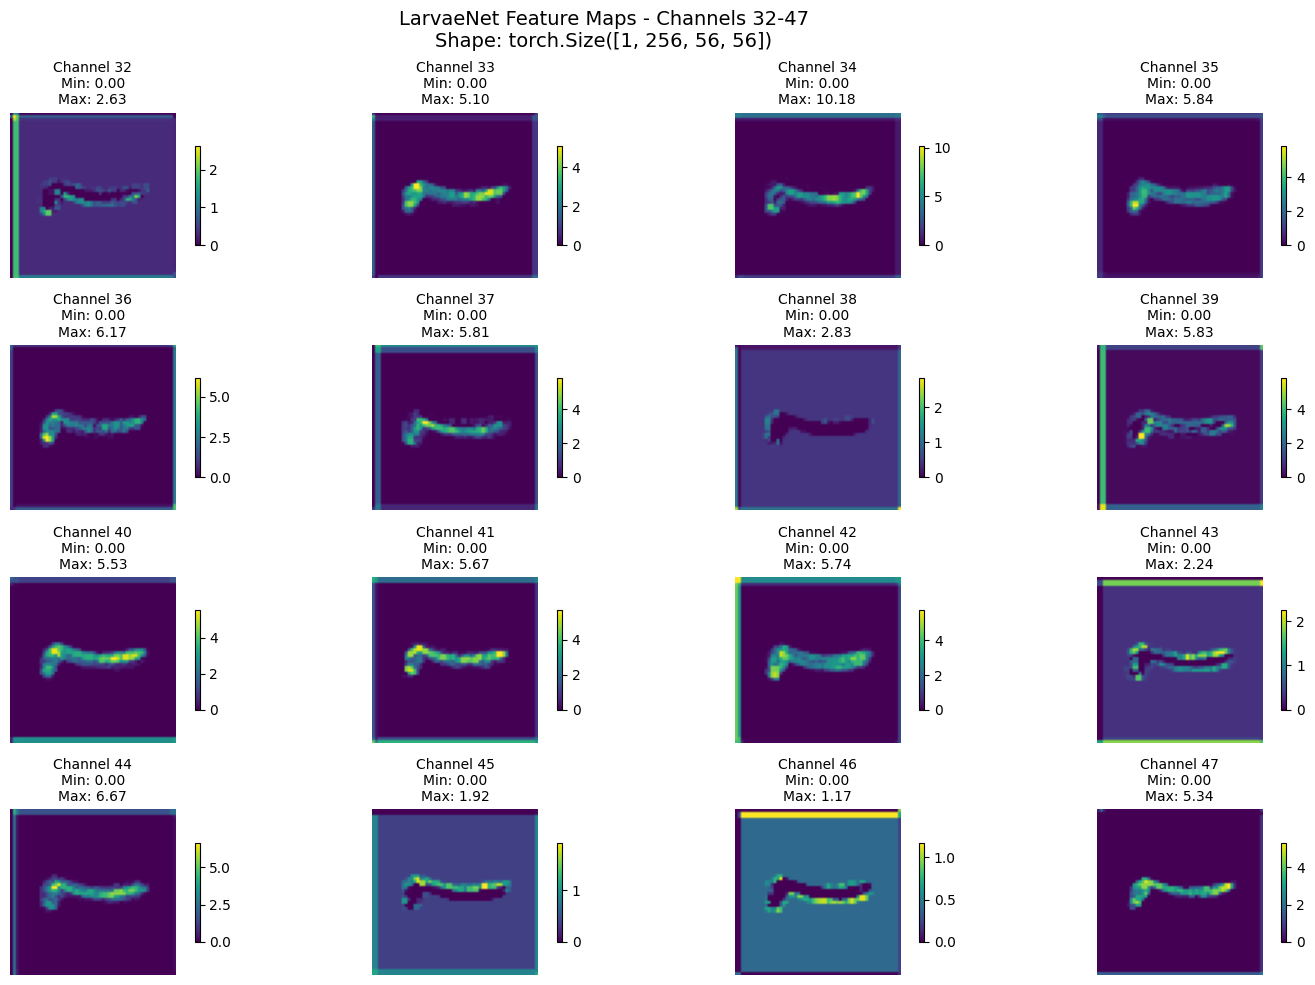

In [66]:
# visualize 16 canais a partir do canal 32
visualize_features(feature_map, max_channels=16, start_channel=32)  

### For uncorrect classification

In [116]:
# Verificar um exemplo de classificação incorreta da rede no conjunto de teste
model = model.to(device)
model.eval()
with torch.no_grad():
    for ims, targets in validload:
        ims = ims.to(device)
        targets = targets.to(device)
        outputs = model(ims)
        preds = torch.argmax(outputs, dim=1)
        uncorrect_mask = preds != targets
        if uncorrect_mask.any():
            idx_error = uncorrect_mask.nonzero(as_tuple=True)[0][0].item()
            break

# idx é o índice do exemplo de classificação incorreta
image_error, target = validset[idx_error] # get idx th image from trainset
image_error.size() # it is a tensor with shape (nchannels, height, width)
image_error = image_error.unsqueeze(0) # add batch dimension

Feature map shape: torch.Size([1, 256, 56, 56])
Total channels: 256
Visualizing channels 32-47 from sample 0


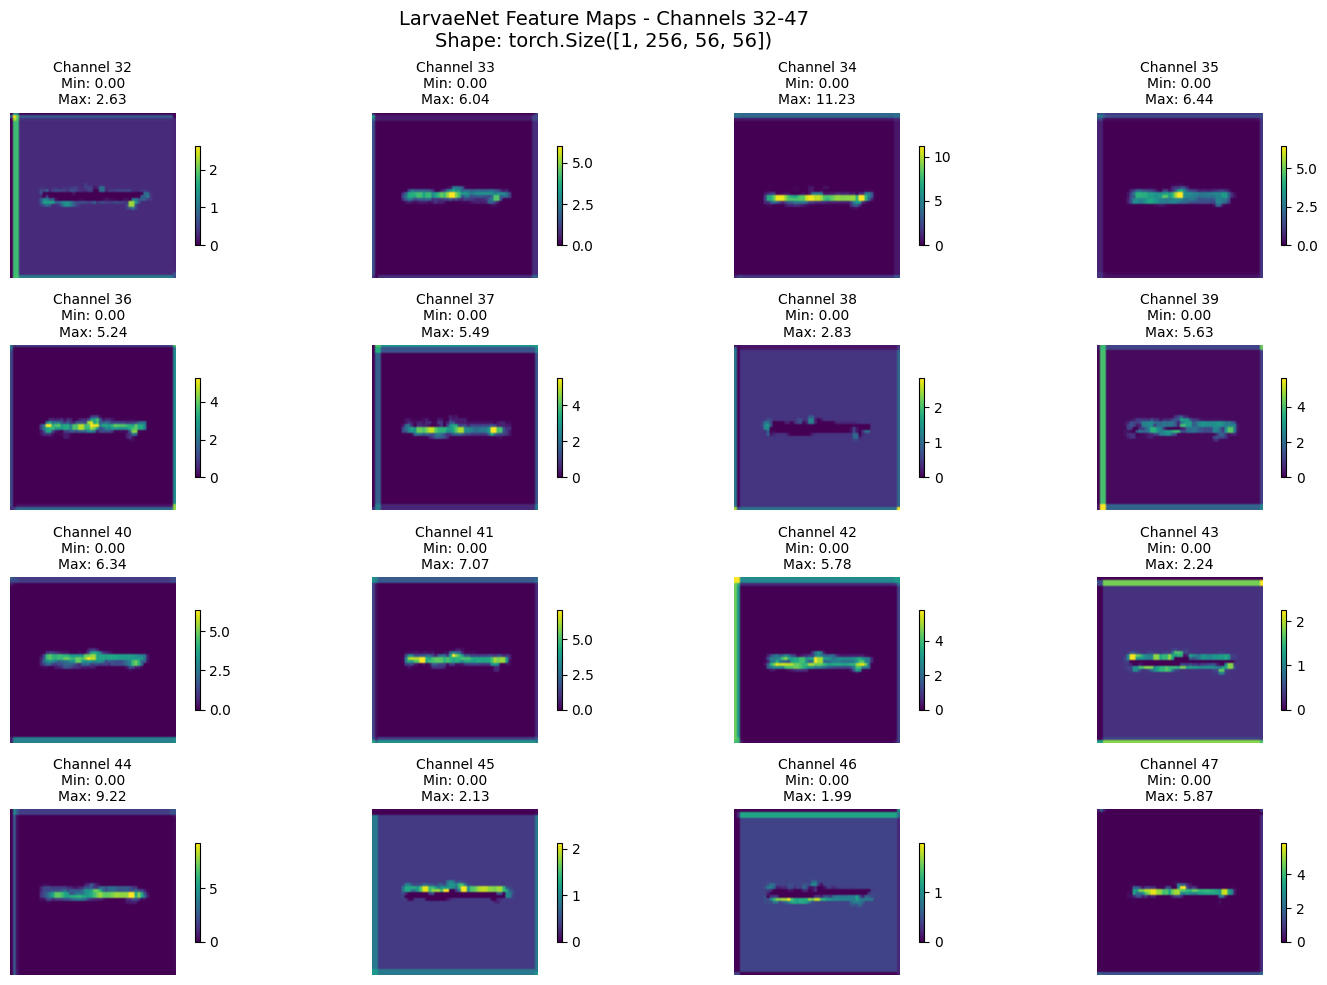

In [117]:
feature_map_error = get_feature_map(model, image_error.to(device)) 
visualize_features(feature_map_error, max_channels=16, start_channel=32)

## Projeções Ativações

In [80]:
# function to get the output of each layer/block in convolutional neural network
from collections import OrderedDict
def get_each_output(model, x):
    #empty dict
    output_by_layer = OrderedDict()
  
    #get the input
    output_by_layer['input'] = x.clone().detach().cpu().data.numpy()

    #for each layer of the feature extractor
    for layer_name, layer in model.features.named_children():
        #do forward through the layer   
        x = layer.forward(x)
        #save the output
        output_by_layer["features-"+layer_name] = x.clone().detach().cpu().numpy()

    x = torch.flatten(x, start_dim=1) # flatten the tensor
    output_by_layer['flattened'] = x.clone().detach().cpu().data.numpy()

    #for each layer of the classifier (note that you could have done that for model.conv1 and model.conv2 as well)
    for layer_name, layer in model.classifier.named_children():
        #do forward through the layer   
        x = layer.forward(x)
        #save the output
        output_by_layer["classifier-"+layer_name] = x.clone().detach().cpu().numpy()
  
    #return output by layer
    return output_by_layer

In [ ]:
#get the outputs, and labels
def get_ouputs(model, dataload, device):
    outputs_by_layer = None
    all_labels = None

    #get a batch from the dataload
    for inputs, labels in dataload:
        #move inputs to the correct device
        inputs = inputs.to(device)
        labels = labels.clone().detach().cpu().numpy()

        #get the activations for visualization
        outputs = get_each_output(model, inputs)
            
        #save the outputs
        if outputs_by_layer is None:
            outputs_by_layer = outputs
            all_labels       = labels
        else:
            for layer in outputs:
                outputs_by_layer[layer] = np.concatenate((outputs_by_layer[layer], outputs[layer]), axis=0)
            all_labels = np.concatenate((all_labels, labels))   

    return outputs_by_layer, all_labels

In [75]:
#maps from high dimension to 2D
def projection(outputs_by_layer, reducer):
    projection_by_layer = OrderedDict()

    for layer in outputs_by_layer:
        #get the output of layer
        output = outputs_by_layer[layer]
        output = output.reshape(output.shape[0], -1)
        #map to 2D
        embedded = reducer.fit_transform(output)
        #save projection
        projection_by_layer[layer] = embedded
  
    return projection_by_layer

In [78]:
# impoet umap and t-sne
import umap.umap_ as umap
from sklearn.manifold import TSNE
from numpy import broadcast_to

In [97]:
#plot the projection of the output of each layer
def create_visualization(projection_by_layer_umap, projection_by_layer_tsne, all_labels):
    
    colors = ['steelblue' if label == 0 else 'firebrick' for label in all_labels]
    
    for layer in projection_by_layer_umap:
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        
        # UMAP plot
        embedded = projection_by_layer_umap[layer]
        scatter1 = axes[0].scatter(embedded[:, 0], embedded[:, 1], c=colors, alpha=0.7)
        axes[0].set_title(f'{layer} - UMAP')
        
        # Criar legenda manual
        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor='steelblue', label='Impurities (0)'),
                           Patch(facecolor='firebrick', label='Larvae (1)')]
        axes[0].legend(handles=legend_elements)
        
        # t-SNE plot  
        embedded2 = projection_by_layer_tsne[layer]
        scatter2 = axes[1].scatter(embedded2[:, 0], embedded2[:, 1], c=colors, alpha=0.7)
        axes[1].set_title(f'{layer} - t-SNE')
        axes[1].legend(handles=legend_elements)
        
        plt.tight_layout()
        plt.show()
        plt.close(fig)

In [98]:
# get the output of each layer
outputs_by_layer, all_labels = get_ouputs(model, validload, device, model_name)

# get tsne projection
reducer = TSNE(perplexity=30)
projection_by_layer_tsne = projection(outputs_by_layer, reducer)

# get umap projection
reducer = umap.UMAP()
projection_by_layer_umap = projection(outputs_by_layer, reducer)

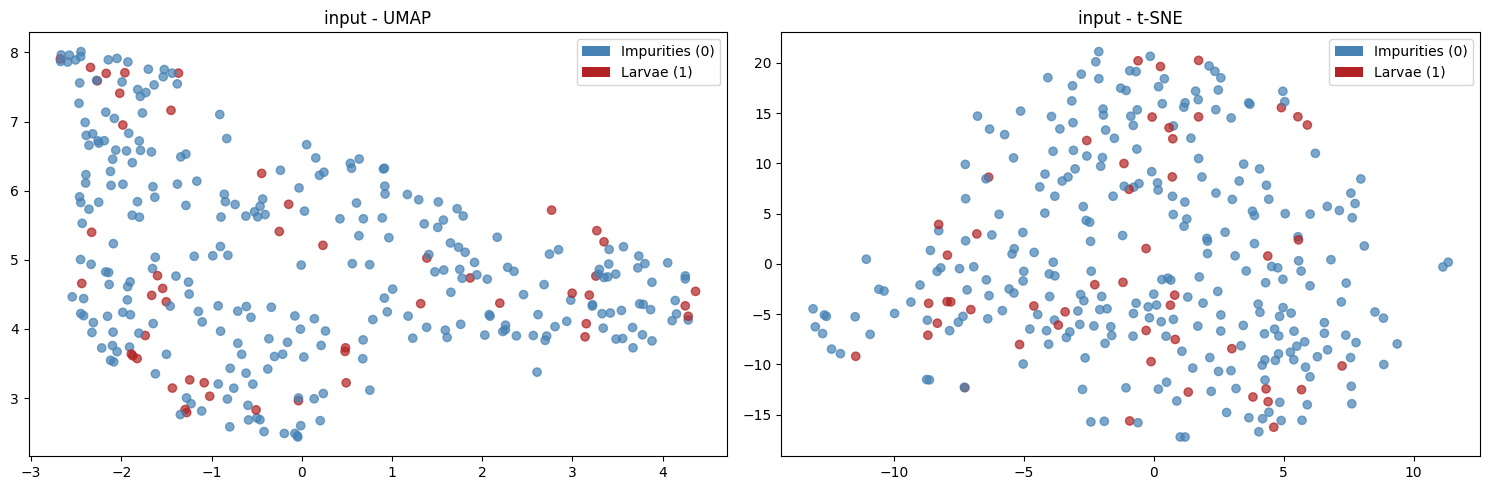

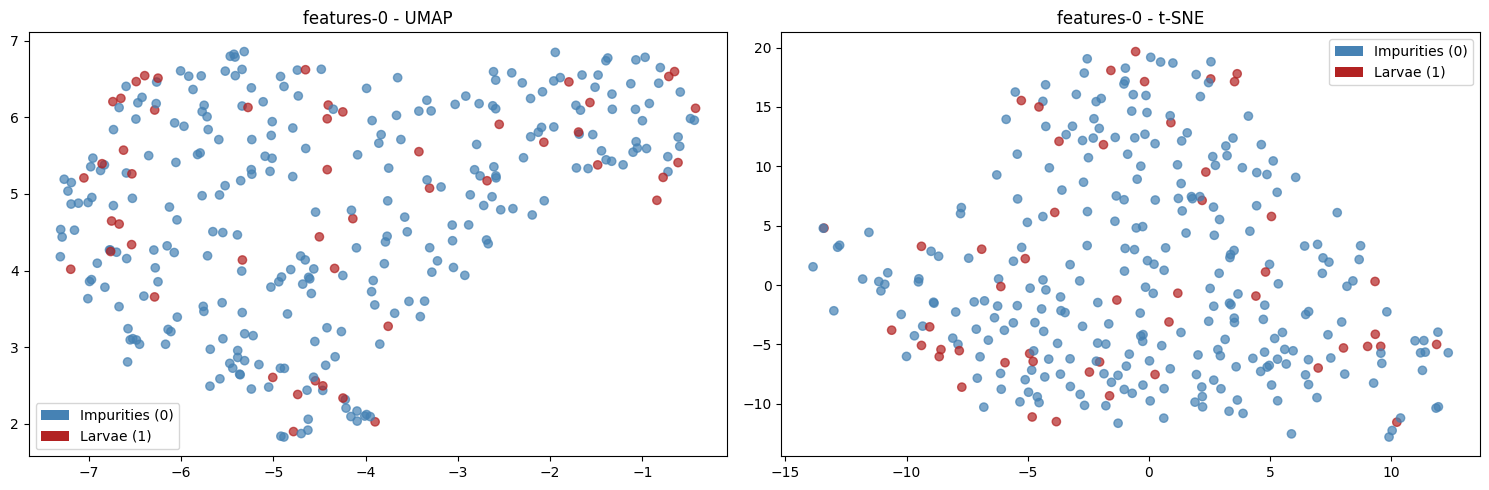

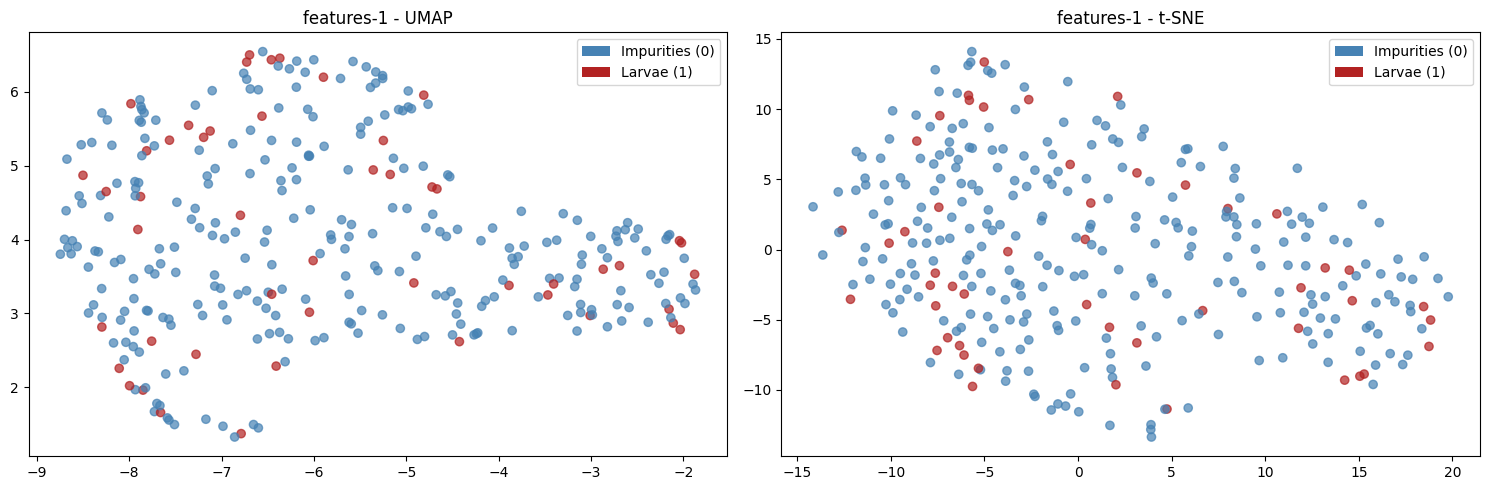

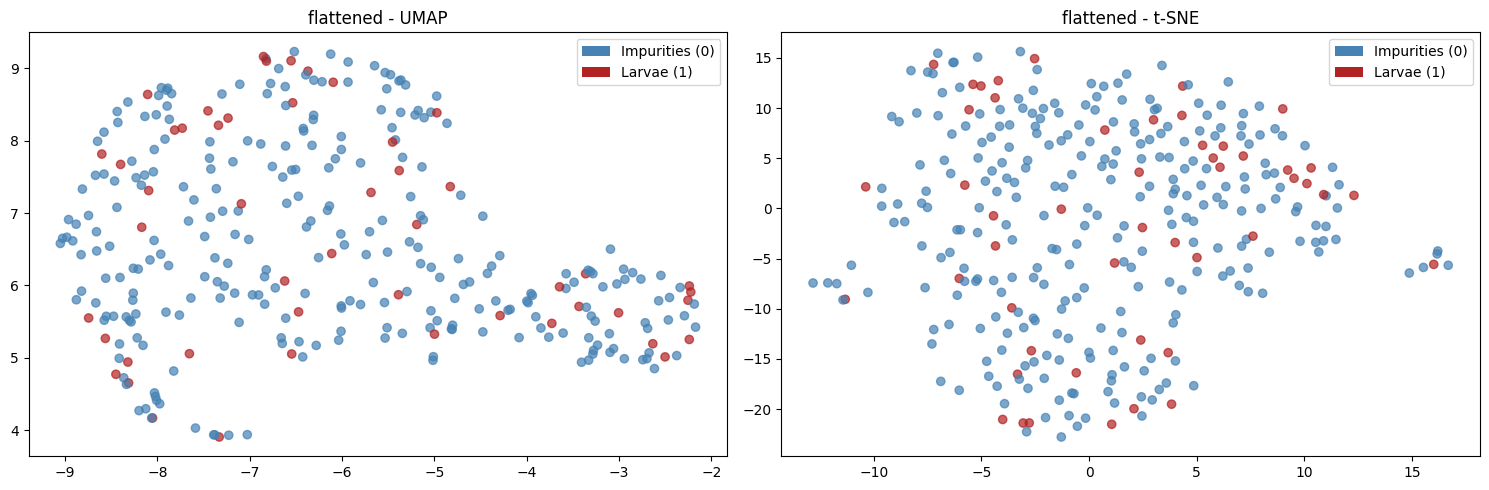

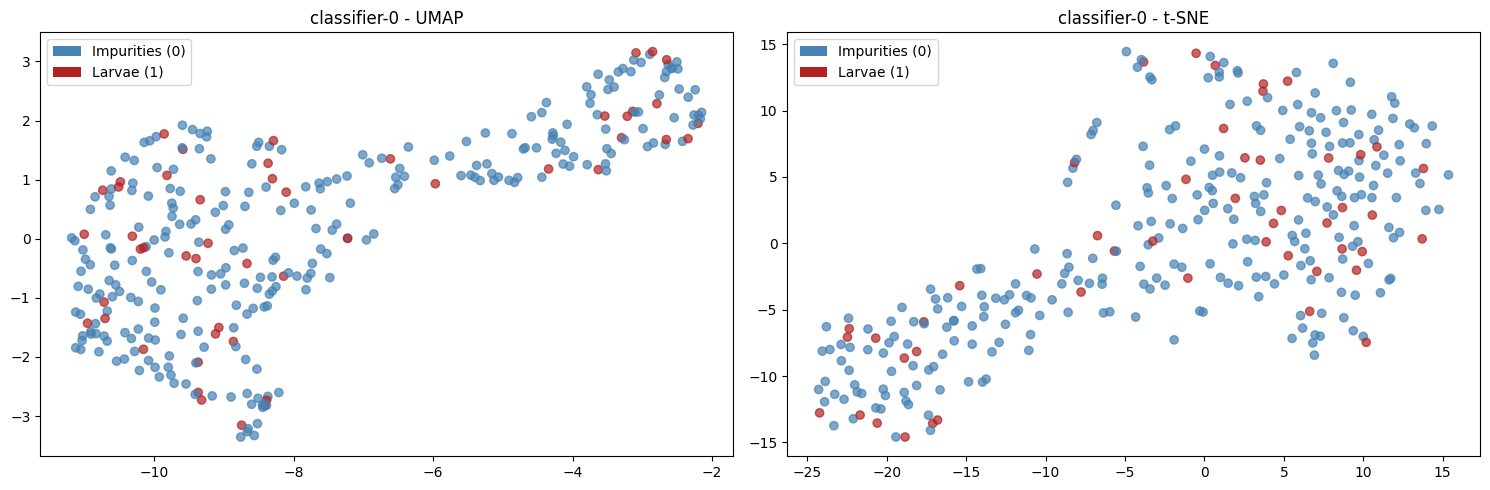

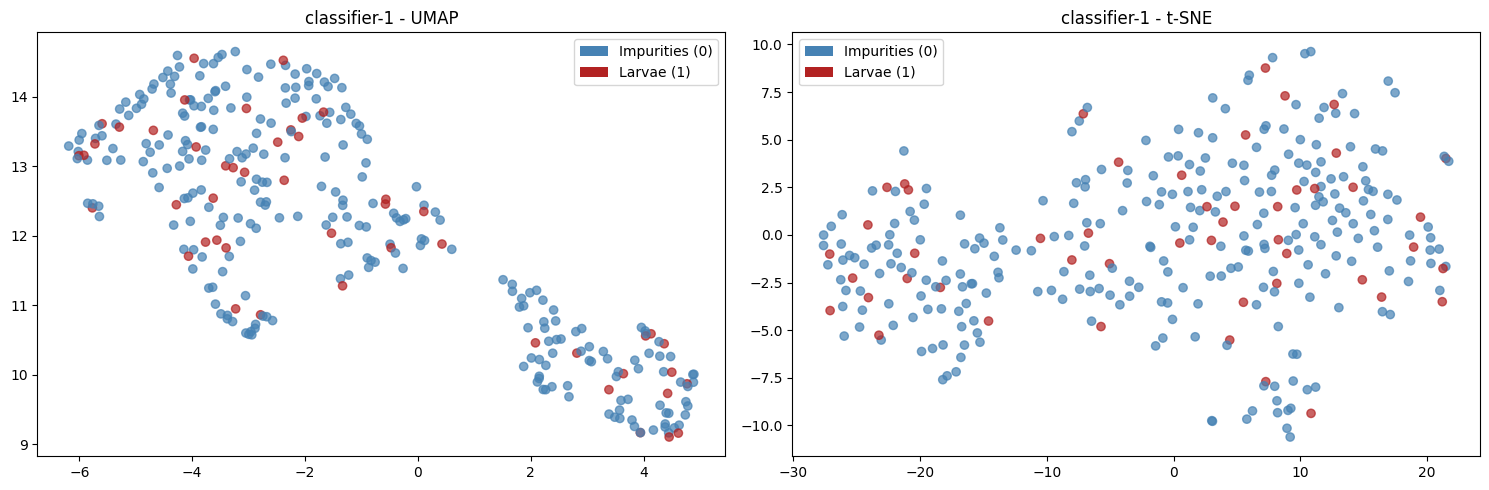

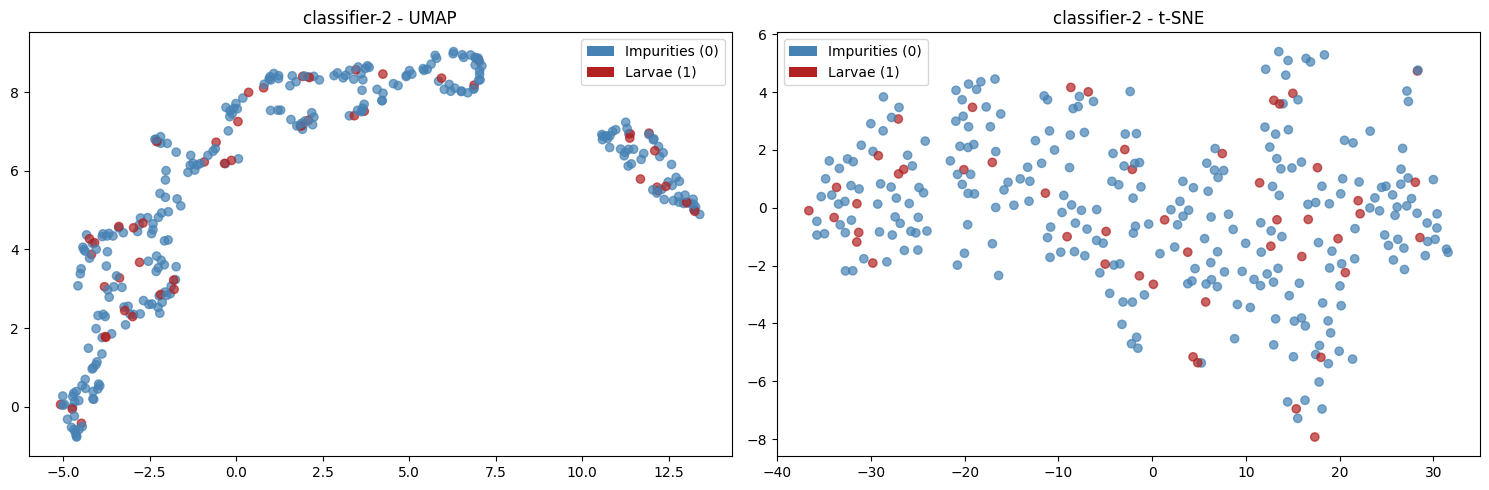

In [103]:
# visualize the projection of the output of each layer
create_visualization(projection_by_layer_umap, projection_by_layer_tsne, valid_labels)

## Regiões de Atenção (GradCAM)

Mostra regiões da imagem que mais influenciaram na decisão do modelo.

In [105]:
# Função para gerar GradCAM
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]
        
    def generate_cam(self, input_image, class_idx=None):
        model_output = self.model(input_image)
        if class_idx is None:
            class_idx = torch.argmax(model_output, dim=1)
        self.model.zero_grad()
        class_score = model_output[:, class_idx]
        class_score.backward()
        gradients = self.gradients
        activations = self.activations
        weights = torch.mean(gradients, dim=[2, 3])
        cam = torch.zeros(activations.shape[2:], dtype=torch.float32).to(input_image.device)
        for i, w in enumerate(weights[0]):
            cam += w * activations[0, i, :, :]
        cam = F.relu(cam)
        cam = cam - torch.min(cam)
        cam = cam / (torch.max(cam) + 1e-8)
        return cam.detach().cpu().numpy()

# Função para gerar GradCAM para um modelo customizado
def gradcam_custom_model(model, image, target_layer_name):
    target_layer = dict(model.named_modules())[target_layer_name]
    grad_cam = GradCAM(model, target_layer)
    cam = grad_cam.generate_cam(image)
    return cam

# Função para visualizar GradCAM
def visualize_gradcam(orig_image, cam, alpha=0.4):
    cam_resized = cv2.resize(cam, (orig_image.shape[1], orig_image.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    overlayed = heatmap * alpha + orig_image * (1 - alpha)
    overlayed = 255*(overlayed - np.min(overlayed)) / (np.max(overlayed)-np.min(overlayed) + 1e-8)
    overlayed = overlayed.astype('uint8')

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(orig_image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    axes[1].imshow(heatmap)
    axes[1].set_title('GradCAM Heatmap')
    axes[1].axis('off')
    
    axes[2].imshow(overlayed.astype(np.uint8))
    axes[2].set_title('Overlayed Result')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

    return overlayed, heatmap


In [118]:
import torch.nn.functional as F
import cv2

conv2d_last_block = model.features[1][0] # get the last conv2d block
for name, module in model.named_modules():
    if module is conv2d_last_block:
        target_layer_name = name
        break

# Generate GradCAM for image = exemplo de classificação correta
cam = gradcam_custom_model(model, image.to(device), target_layer_name)
cam_error = gradcam_custom_model(model, image_error.to(device), target_layer_name)

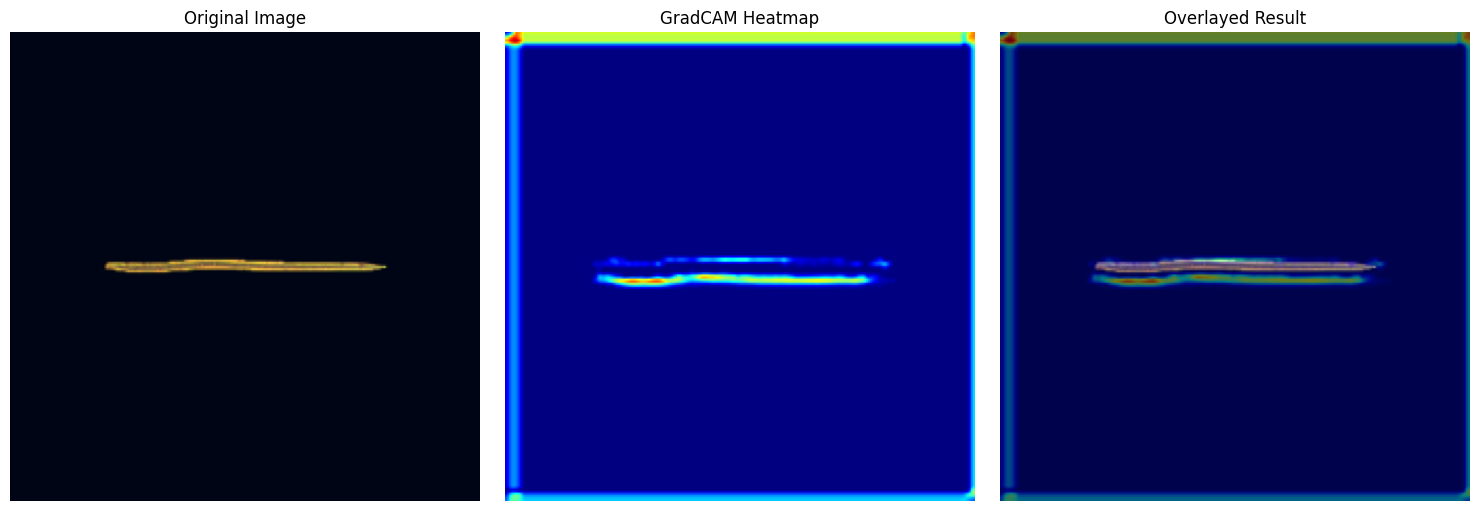

In [ ]:
orig_image, target = validset[idx]  
orig_image = orig_image.permute(1, 2, 0).numpy()
orig_image = 255*(orig_image - np.min(orig_image)) / (np.max(orig_image)-np.min(orig_image))
orig_image = orig_image.astype('uint8')
overlayed, heatmap = visualize_gradcam(orig_image, cam, alpha=0.4)

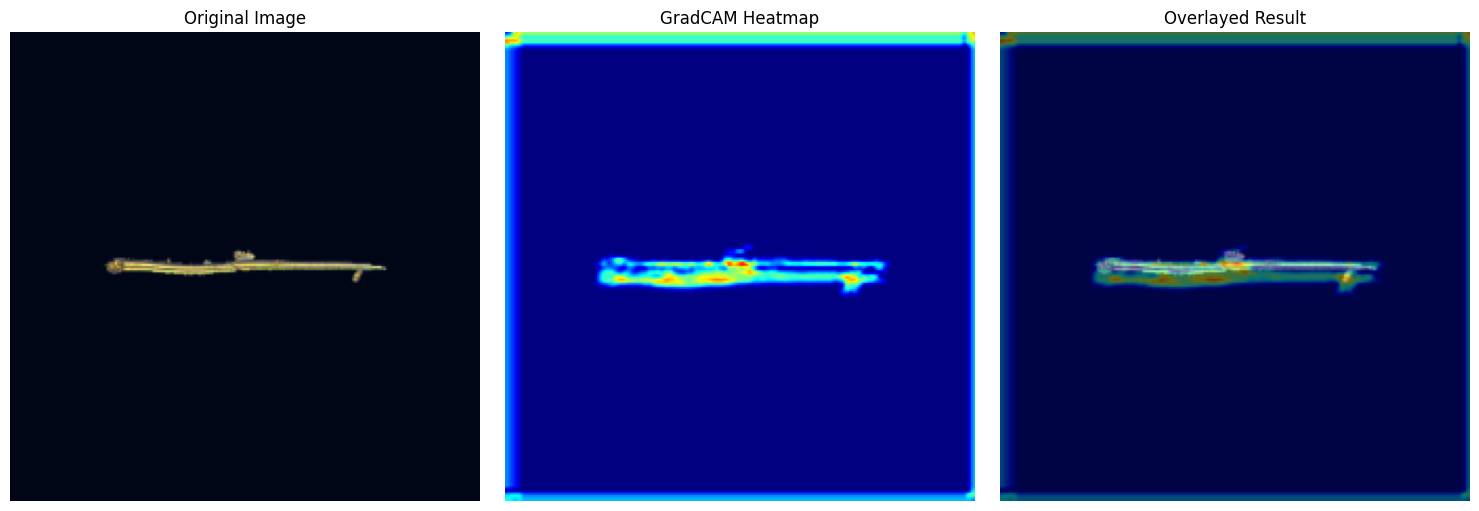

In [119]:
orig_image, target = validset[idx_error]  
orig_image = orig_image.permute(1, 2, 0).numpy()
orig_image = 255*(orig_image - np.min(orig_image)) / (np.max(orig_image)-np.min(orig_image))
orig_image = orig_image.astype('uint8')
overlayed, heatmap = visualize_gradcam(orig_image, cam_error, alpha=0.4)